x_inputs: [0.724030349618226, 0.5747745908564886]
k_pre: [3.0228352900929405, 5.321640230567655, 7.62044517104237]
h_hidden: [0.953595152629268, 0.9951390095912237, 0.9995099167946204]
o_raw: [-1.0410537737565762, -1.0410537737565762]
y_outputs: [0.5, 0.5]
loss: 0.6931471805599453
dldo: [-0.5, 0.5]
dldv: [[-0.476797576314634, 0.476797576314634], [-0.49756950479561185, 0.49756950479561185], [-0.4997549583973102, 0.4997549583973102]]
dldh: [0.0, 0.0, 0.0]
dldc: [-0.5, 0.5]
dldk: [0.0, 0.0, 0.0]
dldw: [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
dldb: [0.0, 0.0, 0.0]
Run : 0
Done epoch: 0
x_inputs: [0.724030349618226, 0.5747745908564886]
k_pre: [3.0228352900929405, 5.321640230567655, 7.62044517104237]
h_hidden: [0.953595152629268, 0.9951390095912237, 0.9995099167946204]
o_raw: [-1.040908840484711, -1.041198707028441]
y_outputs: [0.500072466635425, 0.49992753336457496]
loss: 0.6930022577909071
dldo: [-0.49992753336457496, 0.49992753336457496]
dldv: [[-0.47672847248236533, 0.47672847248236533], [-0.4

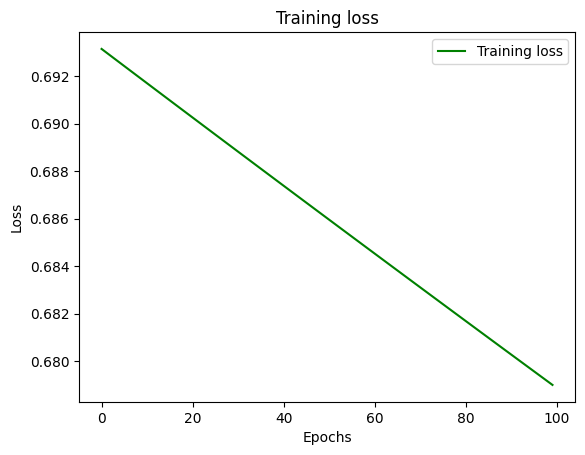

In [8]:
import math
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + (math.exp(-x)))

def softmax(i, outputs):
    den = 0
    for j in range(len(outputs)):
        den += math.e ** outputs[j]
        
    if den == 0:
        return 0
    
    return (math.e ** outputs[i]) / den

def cross_entropy(y, t):
    ce = -1 * t * math.log(y)
    return ce

def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = arr.max() - arr.min()    
    for i in arr:
        temp = (((i - arr.min())*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

def target_arr(num_cls, t):
    arr = [0] * num_cls
    arr[t] = 1
    return arr

class MLP:
    def __init__(self):
        self.logs = True
    
    def forward(self, x_inputs, w_weights, b_weights, v_weights, c_weights):
        k_pre = [0.0, 0.0, 0.0]
        h_hidden = [0.0, 0.0, 0.0]
        o_raw = [0.0, 0.0]
        y_outputs = [0.0, 0.0]
        
        if self.logs: print(f'x_inputs: {x_inputs}')
        
        for j in range(3): 
            for i in range(2):
                k_pre[j] += w_weights[i][j] * x_inputs[i]
            k_pre[j] += b_weights[j]
        if self.logs: print(f'k_pre: {k_pre}') 
        
        for i in range(3):
            h_hidden[i] = sigmoid(k_pre[i])
        if self.logs: print(f'h_hidden: {h_hidden}') 
        
        for j in range(2): 
            for i in range(3): 
                o_raw[j] += v_weights[i][j] * h_hidden[i] 
            o_raw[j] += c_weights[j]
        if self.logs: print(f'o_raw: {o_raw}') 
        
        
        for i in range(2):
            y_outputs[i] = softmax(i, o_raw)
        if self.logs: print(f'y_outputs: {y_outputs}') 
        
        return y_outputs, h_hidden
            
        
    def loss(self, y_outputs, t_targets):
        # print(y_outputs, t_targets)
        loss = 0
        for i in range(2):
            loss += cross_entropy(y_outputs[i], t_targets[i])
        if self.logs: print(f'loss: {loss}')  
        
        return loss
        
    def backward(self, y_outputs, t_targets, h_hidden, v_weights, x_inputs, dldw, dldb, dldv, dldc):
        dldh = [0.0, 0.0, 0.0]
        dldk = [0.0, 0.0, 0.0]
        dldo = [0.0, 0.0]
        # dldy = [0.0, 0.0]
        
        for i in range(2):
            dldo[i] = y_outputs[i] - t_targets[i]
        if self.logs: print(f'dldo: {dldo}')
        
        for j in range(3):
            for i in range(2):
                dldv[j][i] = dldo[i] * h_hidden[j]
                dldh[j] += dldo[i] * v_weights[j][i]      
        if self.logs: print(f'dldv: {dldv}')
        if self.logs: print(f'dldh: {dldh}')
        
        dldc = dldo
        if self.logs: print(f'dldc: {dldc}')
        
        for i in range(3):
            dldk[i] = dldh[i] * h_hidden[i] * (1 - h_hidden[i]) 

        if self.logs: print(f'dldk: {dldk}')
            
        for j in range(3):
            for i in range(2):
                dldw[i][j] = dldk[j] * x_inputs[i] 
            
        dldb = dldk

        if self.logs: print(f'dldw: {dldw}')
        if self.logs: print(f'dldb: {dldb}')
        
        return dldw, dldb, dldv, dldc
        
    def set_inputs(self, x_inputs):
        self.x_inputs = x_inputs
        
    def set_targets(self, t_targets):
        self.t_targets = t_targets
        
    def set_learning_rate(self, lr):
        self.lr = lr
        
    def sgd(self, lr, w_weights, b_weights, v_weights, c_weights, dldw, dldb, dldv, dldc):
        for j in range(3):
            for i in range(2):
                diff = -lr * dldv[j][i]
                # if logs: print(f'diff v: {diff}')
                v_weights[j][i] += diff
                
        for j in range(2):
            for i in range(3):
                diff = -lr * dldw[j][i]
                # if logs: print(f'diff w: {diff}')
                w_weights[j][i] += diff
                
        for j in range(2):
            diff = -lr * dldc[j]
            # if logs: print(f'diff w: {diff}')
            c_weights[j] += diff
        
        for j in range(3):
            diff = -lr * dldb[j]
            # if logs: print(f'diff w: {diff}')
            b_weights[j] += diff
            
        return v_weights, w_weights, c_weights, b_weights
    
from data import load_synth
(xtrain, ytrain), (xval, yval), num_cls = load_synth()

a_learning_rate = 1e-4
mlp = MLP()
mlp.set_learning_rate(a_learning_rate)

losses = []
epochs = 1

dldh = [0.0, 0.0, 0.0]
dldk = [0.0, 0.0, 0.0]
dldo = [0.0, 0.0]
dldy = [0.0, 0.0]

dldw = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
dldv = [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]
dldb = [0.0, 0.0, 0.0]
dldc = [0.0, 0.0]
     
w_weights = [[2.0, 3.0, 4.0], [1.0, 2.0, 3.0]]
b_weights = [1.0, 2.0, 3.0] 
v_weights = [[1.0, 1.0], [-1.0, -1.0], [-1.0, -1.0]]  # rand_weights(3, 2) # # 
c_weights = [0.0, 0.0]

norm_train_x = normalize(xtrain, 0, 1)
norm_val_x = normalize(xval, 0, 1)

norm_train_y = normalize(ytrain, 0, 1)
norm_val_y = normalize(yval, 0, 1)

for j in range(100):
    loss_avg = []
    
    dldw = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    dldb = [0.0, 0.0, 0.0]
    dldv = [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]
    dldc = [0.0, 0.0]
    
    for i in range(1):
        x1, x2 = norm_train_x[i]
        y = 0 if norm_train_y[i] == 1 else 1 
        t_targets = target_arr(num_cls, y)
        
        x_inputs = [x1, x2]
        # print('working1')
        y_outputs, h_hidden = mlp.forward(x_inputs, w_weights, b_weights, v_weights, c_weights)
        # print('working2')
        loss = mlp.loss(y_outputs, t_targets)
        # print('working3')
        w_pri, b_pri, v_pri, c_pri = mlp.backward(y_outputs, t_targets, h_hidden, v_weights, x_inputs, dldw, dldb, dldv, dldc)
        # print('working4')
        dldw += w_pri
        dldb += b_pri
        dldv += v_pri
        dldc += c_pri
        
        # losses.append(loss)
        
        # print(losses)
        if i % 10 == 0:
            print(f'Run : {i}')
            losses.append(loss)
            
    v_weights, w_weights, c_weights, b_weights = mlp.sgd(a_learning_rate, w_weights, b_weights, v_weights, c_weights, dldw, dldb, dldv, dldc)
    print(f'Done epoch: {j}')
            
    
    
    

loss_train = losses
episodes = range(0,len(losses))
plt.plot(episodes, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
    

In [5]:
def cross_entropy(y, t):
    ce = -1 * t * math.log(y)
    return ce

In [10]:
p = [0.1, 0.5, 0.1, 0.1, 0.2]
q = [1, 0, 0, 0, 0]
loss = 0
for i in range(len(p)):
    loss += cross_entropy(p[i], q[i])
    
print(loss)

2.3025850929940455


In [4]:
class MLP:
    def __init__(self, x_inputs, t_targets):
        self.x_inputs = x_inputs
        self.t_targets = t_targets
        self.k_pre = [0.0, 0.0, 0.0]
        self.h_hidden = [0.0, 0.0, 0.0]
        self.w_weights = [[1.0, 1.0, 1.0], [-1.0, -1.0, -1.0]]
        self.v_weights = [[1.0, 1.0], [-1.0, -1.0], [-1.0, -1.0]]
        self.b_bias = 0
        self.c_bias = 0
        self.y_outputs = [0.0, 0.0]
        self.o_raw = [0.0, 0.0]
        self.loss = 0
        
        self.dldv = [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]
        self.dldh = [0.0, 0.0, 0.0]
        self.dldc = 0.0
        self.dldk = [0.0, 0.0, 0.0]
        self.dldw = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
        self.dldb = [0.0, 0.0, 0.0]
        self.dldo = [0.0, 0.0]
        self.dldy = [0.0, 0.0]
    
    def forward(self):
        for j in range(3):
            for i in range(2):
                self.k_pre[j] += self.w_weights[i][j] * self.x_inputs[i]
            self.k_pre[j] += self.b_bias
        
        for i in range(3):
            self.h_hidden[i] = sigmoid(self.k_pre[i])
        
        for j in range(2):
            for i in range(3):
                self.o_raw[j] += self.v_weights[i][j] * self.h_hidden[i] 
            self.o_raw[j] += self.c_bias
        
        for i in range(2):
            self.y_outputs[i] = softmax(i, self.o_raw)
            
        for i in range(2):
            self.loss += cross_entropy(self.y_outputs[i], self.t_targets[i])
        
        return self.loss
    
    def backward(self):
        for i in range(2):
            self.dldy[i] = -1 * self.t_targets[i] * (1 / self.y_outputs[i])

        for i in range(2):
            self.dldo[i] = self.y_outputs[i] - self.t_targets[i]
        
        for j in range(3):
            for i in range(2):
                self.dldv[j][i] = self.dldo[i] * self.h_hidden[j]
                self.dldh[j] += self.dldo[i] * self.v_weights[j][i]     
        
        self.dldc = self.dldo
        
        for i in range(3):
            self.dldk[i] = self.dldh[i] * self.h_hidden[i] * (1 - self.h_hidden[i])
            
        for j in range(3):
            for i in range(2):
                self.dldw[i][j] = self.dldk[j] * self.x_inputs[i]
            self.dldb[j] = self.dldk[j]

mlp = MLP([1, -1], [1, 0])
loss = mlp.forward()
mlp.backward()

print(loss)

0.6931471805599453
